### Comparation between existing model vs our model

In [12]:
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


In [13]:
# Define alphabets with uppercase English letters (A-Z), digits (0-9), and special characters
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789*^_)(- .',"
max_str_len = 34  # max length of input labels
num_of_characters = len(alphabets) + 1  # +1 for CTC pseudo blank
num_of_timestamps = 100  # max length of predicted labels

# Function to convert label (string) to numerical representation

def label_to_num(label):
    label_num = []
    for ch in label:
        idx = alphabets.find(ch)
        if idx == -1:  # This means the character is not found in the alphabet
            raise ValueError(f"Character '{ch}' not in alphabet.")
        label_num.append(idx)
    return np.array(label_num)


def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

### Our model

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


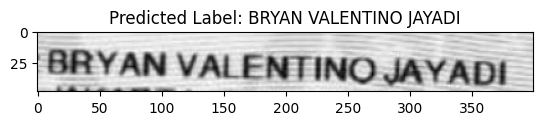

Predicted label: BRYAN VALENTINO JAYADI


In [14]:
# Load the model
model = tf.keras.models.load_model('C:/Adhi/code/capstone/arial.h5')
# Function to load, resize, rotate and preprocess the image
def preprocess_image(image_path, target_height=48, target_width=400):
    # Load the image using OpenCV
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale (single channel)
    
    # Resize the image to the target dimensions (400x48)
    img_resized = cv2.resize(img, (target_width, target_height))
    
    # Normalize the image to [0, 1] range
    img_resized = img_resized / 255.0
    
    # Rotate the image 90 degrees clockwise
    img_resized = cv2.rotate(img_resized, cv2.ROTATE_90_CLOCKWISE)
    
    # Add batch and channel dimensions (for grayscale: (1, 400, 48, 1))
    img_resized = np.expand_dims(img_resized, axis=-1)  # Add channel dimension
    img_resized = np.expand_dims(img_resized, axis=0)  # Add batch dimension
    
    return img_resized

# Load and preprocess the image
image_path = "C:/Adhi/code/capstone/synthetic_data/generated_images_arial/BRYAN VALENTINO JAYADI.jpg"  # Update with your image path
image = preprocess_image(image_path)

# Make the prediction
preds = model.predict(image)

# CTC Decode
input_length = np.ones(preds.shape[0]) * preds.shape[1]  # Use the length of the output sequence
decoded = tf.keras.backend.get_value(tf.keras.backend.ctc_decode(preds, input_length=input_length, greedy=True)[0][0])

# Convert the predicted labels back to text
prediction = num_to_label(decoded[0])

# Plot the image and display the predicted label
plt.imshow(cv2.rotate(image[0, :, :, 0], cv2.ROTATE_90_COUNTERCLOCKWISE), cmap='gray')
plt.title(f'Predicted Label: {prediction}')
plt.show()

# Print the prediction
print("Predicted label:", prediction)


In [15]:
import os
import cv2
import numpy as np
import tensorflow as tf

# Preprocess image function
def preprocess_image(image_path, target_height=48, target_width=400):
    """
    Preprocess the image for the model.
    Args:
        image_path (str): Path to the image file.
        target_height (int): Target height of the image.
        target_width (int): Target width of the image.
    Returns:
        np.ndarray: Preprocessed image ready for model input.
    """
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
    img_resized = cv2.resize(img, (target_width, target_height))  # Resize to target dimensions
    img_resized = img_resized / 255.0  # Normalize to [0, 1]
    img_resized = cv2.rotate(img_resized, cv2.ROTATE_90_CLOCKWISE)  # Rotate 90 degrees
    img_resized = np.expand_dims(img_resized, axis=-1)  # Add channel dimension
    img_resized = np.expand_dims(img_resized, axis=0)  # Add batch dimension
    return img_resized

# Function to decode CTC predictions to text
def decode_ctc_predictions(preds, input_length):
    """
    Decodes CTC predictions to text using greedy decoding.
    Args:
        preds (np.ndarray): Predictions from the model.
        input_length (np.ndarray): Length of input sequences.
    Returns:
        list of str: Decoded text predictions.
    """
    decoded = tf.keras.backend.get_value(
        tf.keras.backend.ctc_decode(preds, input_length=input_length, greedy=True)[0][0]
    )
    return [num_to_label(seq) for seq in decoded]

# Function to compute accuracy for a folder of images with logging
def calculate_folder_accuracy(folder_path, model, target_height=48, target_width=400):
    """
    Calculates accuracy for all images in a folder.
    Args:
        folder_path (str): Path to the folder containing images.
        model (tf.keras.Model): Trained CTC model.
        target_height (int): Target height of the image.
        target_width (int): Target width of the image.
    Returns:
        float: Accuracy as a percentage.
    """
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    correct = 0
    total = len(image_files)

    for idx, image_file in enumerate(image_files, start=1):
        # Ground truth label from filename
        label = os.path.splitext(image_file)[0]  # Filename without extension
        try:
            label_num = label_to_num(label)  # Convert label to numerical form
        except ValueError as e:
            print(f"[{idx}/{total}] Skipping file {image_file}: {e}")
            continue

        # Preprocess the image
        image_path = os.path.join(folder_path, image_file)
        image = preprocess_image(image_path, target_height, target_width)

        # Predict using the model
        preds = model.predict(image)
        input_length = np.ones(preds.shape[0]) * preds.shape[1]  # Length of predicted sequence
        predictions = decode_ctc_predictions(preds, input_length)
        prediction = predictions[0] if predictions else ""

        # Log each prediction
        match_status = "CORRECT" if prediction == label else "WRONG"
        print(f"[{idx}/{total}] File: {image_file}")
        print(f"  - Ground Truth: {label}")
        print(f"  - Prediction:   {prediction}")
        print(f"  - Status:       {match_status}")

        # Check if prediction matches the label
        if prediction == label:
            correct += 1

    accuracy = (correct / total) * 100 if total > 0 else 0
    print(f"\nTotal Accuracy: {accuracy:.2f}%")
    return accuracy

# Main function to compute accuracy
if __name__ == "__main__":
    # Folder path with images
    folder_path = "C:/Adhi/code/capstone/test"  # Update this with your folder path

    # Load the trained model
    model = tf.keras.models.load_model('C:/Adhi/code/capstone/ar_ver2.h5')

    # Calculate accuracy
    accuracy = calculate_folder_accuracy(folder_path, model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step
[1/29] File: RIDA RARASATI.jpg
  - Ground Truth: RIDA RARASATI
  - Prediction:   RIDA RARASATI
  - Status:       CORRECT
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
[2/29] File: RISKI SAPUTRA.jpg
  - Ground Truth: RISKI SAPUTRA
  - Prediction:   RISKI SAPUTRA
  - Status:       CORRECT
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
[3/29] File: SAEFUDIN.jpg
  - Ground Truth: SAEFUDIN
  - Prediction:   SAEFUDIN
  - Status:       CORRECT
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
[4/29] File: SALMAA ARIIBAH IMTINAAN.jpg
  - Ground Truth: SALMAA ARIIBAH IMTINAAN
  - Prediction:   SALMAA ARIIBAH IMTINAAN
  - Status:       CORRECT
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
[5/29] File: SEKAR PUTIH.jpg
  - Ground Truth: SEKAR PUTIH
  - Prediction:   SEKAR PUTIH
  - Status:       CORRECT
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
[6/29] File: SELA TAMTAMA.jpg
  - Ground Truth: SELA TAMTAMA
  - Prediction:   SELA TAMTAMA
  - Status:       CORRECT
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
[

### pytesseract OCR Model

In [16]:
import os
import cv2
import numpy as np
import pytesseract
from PIL import Image

# Function to predict using Tesseract OCR (No preprocessing)
def predict_with_tesseract(image_path):
    """
    Predicts text from the image using Tesseract OCR.
    Args:
        image_path (str): Path to the image file.
    Returns:
        str: Text prediction from Tesseract.
    """
    # Read the image directly in grayscale (no preprocessing)
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Convert the image to PIL format for pytesseract
    pil_img = Image.fromarray(img)
    
    # Use Tesseract to extract text
    text = pytesseract.image_to_string(pil_img, config='--psm 6').strip()
    return text

# Function to compute accuracy for a folder of images with logging (using Tesseract)
def calculate_folder_accuracy(folder_path):
    """
    Calculates accuracy for all images in a folder using Tesseract OCR.
    Args:
        folder_path (str): Path to the folder containing images.
    Returns:
        float: Accuracy as a percentage.
    """
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    correct = 0
    total = len(image_files)

    for idx, image_file in enumerate(image_files, start=1):
        # Ground truth label from filename
        label = os.path.splitext(image_file)[0]  # Filename without extension

        # Get the full path to the image file
        image_path = os.path.join(folder_path, image_file)

        # Predict using Tesseract
        prediction = predict_with_tesseract(image_path)

        # Log each prediction
        match_status = "CORRECT" if prediction == label else "WRONG"
        print(f"[{idx}/{total}] File: {image_file}")
        print(f"  - Ground Truth: {label}")
        print(f"  - Prediction:   {prediction}")
        print(f"  - Status:       {match_status}")

        # Check if prediction matches the label
        if prediction == label:
            correct += 1

    accuracy = (correct / total) * 100 if total > 0 else 0
    print(f"\nTotal Accuracy: {accuracy:.2f}%")
    return accuracy

# Main function to compute accuracy
if __name__ == "__main__":
    # Folder path with images
    folder_path = "C:/Adhi/code/capstone/test"  # Update this with your folder path

    # Calculate accuracy using Tesseract OCR
    accuracy = calculate_folder_accuracy(folder_path)


[1/29] File: RIDA RARASATI.jpg
  - Ground Truth: RIDA RARASATI
  - Prediction:   RIDA RARASATI
  - Status:       CORRECT
[2/29] File: RISKI SAPUTRA.jpg
  - Ground Truth: RISKI SAPUTRA
  - Prediction:   - RISKELSAPUTRA
  - Status:       WRONG
[3/29] File: SAEFUDIN.jpg
  - Ground Truth: SAEFUDIN
  - Prediction:   SAEFUOIN.
  - Status:       WRONG
[4/29] File: SALMAA ARIIBAH IMTINAAN.jpg
  - Ground Truth: SALMAA ARIIBAH IMTINAAN
  - Prediction:   SALMAA ARIIBAH IMTINAAN
  - Status:       CORRECT
[5/29] File: SEKAR PUTIH.jpg
  - Ground Truth: SEKAR PUTIH
  - Prediction:   
  - Status:       WRONG
[6/29] File: SELA TAMTAMA.jpg
  - Ground Truth: SELA TAMTAMA
  - Prediction:   SELA TAMTAMA
  - Status:       CORRECT
[7/29] File: SEMINGKIR.jpg
  - Ground Truth: SEMINGKIR
  - Prediction:   — eee
  - Status:       WRONG
[8/29] File: SEPATEN.jpg
  - Ground Truth: SEPATEN
  - Prediction:   SEPATEN
  - Status:       CORRECT
[9/29] File: SISWANTI.jpg
  - Ground Truth: SISWANTI
  - Prediction:   SeWAN